

# Final Project EI - Identification and correlation of risk factors on lung cancer

    - Group 7

    - Élèves: Victor Freitas Teodoro - Théo Cavina - Julie Dupuis - Yann-Raphaël Berndt - Aloïse Parruitte 


-----
# Table of Content

1. [Cap1](#Cap1)
2. [Definig the patients of interest](#Cap1)
3. [Deduplication](#Cap2)
4. [First Analysis of the population](#Cap4)
5. [Checking for other conditions in patients with diagnosed lung cancer](#Cap5)
6. [Comparing conditions and biological measures between cancer patients and the other patients](#Cap6)[
7. [Conclusion](#Conc) 


<a id="Cap1"></a>
# 1. Knowing the Data

We first open all the datasets to see what we are working with and to have a better idea of how the different pieces of data connect (if they do) with eachother.

In [2928]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2929]:
df_cond = pd.read_pickle("data/df_condition.pkl")
df_bio = pd.read_pickle("data/df_bio.pkl")
df_dedup_det = pd.read_pickle("data/df_dedup_deterministic.pkl")
df_dedup_proba = pd.read_pickle("data/df_dedup_proba.pkl")
df_dedup = pd.read_pickle("data/df_dedup.pkl")
df_note = pd.read_pickle("data/df_note.pkl")
df_note_nlp = pd.read_pickle("data/df_note_nlp.pkl")
df_person = pd.read_pickle("data/df_person.pkl")
df_visit = pd.read_pickle("data/df_visit.pkl")


We manage to create this schema to help the visualization of how the datasets interact

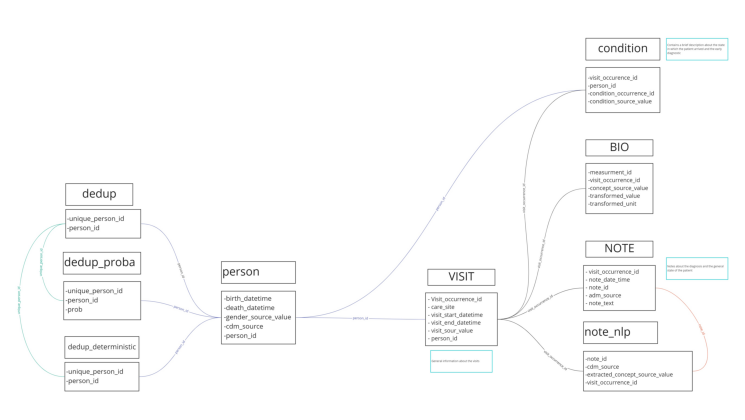

In [2930]:
img = plt.imread('data/schema_miro.jpg')
plt.figure(figsize=(15,6))
plt.imshow(img) 
plt.axis('off')
plt.show()

<a id="Cap2"></a>
# 2. Defining the patients of interest

To define what patients we wi'll work with, we check what occurrencies are presented in the dataset, knowing that we will study the ones that are directly related to cancer, and later check if the patients presenting these occurrencies have presented other occurrencies on the dataset.

In [2931]:
df_cond = pd.read_pickle("data/df_condition.pkl")
df_cond.head()

,visit_occurrence_id,person_id,condition_occurrence_id,condition_source_value
0,82199313.0,87118775,86873029.0,C19
1,84796321.0,85828583,83986168.0,F023
2,83914646.0,88459112,81096634.0,G20
3,84893973.0,88291057,85075207.0,F023
4,88339649.0,89239332,82190905.0,G20


- Aiming to figure out which of the patients are interesting for the study. We will first check what codes of ICD-10 were registered on data.

In [2932]:
df_cond.value_counts("condition_source_value")

condition_source_value
K70     2474
C50     2170
G20     2159
F023    2138
C19     2072
Z801    1467
T51     1465
F10     1297
I15      522
I12      465
C343     431
C342     421
C341     403
Z864     396
I13      395
C34      377
C340     376
Z716     362
Z587     262
Z720     152
E11      102
E12       84
E10       35
B22        1
B21        1
dtype: int64

- We discover that 25 different codes were registered, so we need to check which among them indicate the presence of lung cancer and which are indirectly related to it. We search on www.aideaucodage.fr for the meaning of these codes and choose the most related to the study. 

Occurrences of cancer

- C343 - Tumeur maligne du lobe inférieur, bronches ou poumon
- C342 - Tumeur maligne du lobe moyen, bronches ou poumon
- C341 - Tumeur maligne du lobe supérieur, bronches ou poumon
- C34 - Tumeur maligne des bronches et du poumon
- C340 - Tumeur maligne de la bronche souche

-------
Occurrences pottentially linked to lung cancer

- Z801 - Antécédents familiaux de tumeur maligne de la trachée, des bronches et des poumons
- Z716 - Conseil pour tabagisme
- Z587 - Exposition à la fumée du tabac
- Z720 - Difficultés liées à l'usage du tabac
- Z864 - Antécédents personnels d'abus de substances psycho-actives
- T51 - Effet toxique de l'alcool
- F10 - Troubles mentaux et du comportement liés à l'utilisation d'alcool
- K70 - Maladie alcoolique du foie
- E12 - Diabète sucré de malnutrition
- E11 - Diabète sucré de type 2
- E10 - Diabète sucré de type 1
- B21 - Immunodéficience humaine virale [VIH], à l'origine de tumeurs malignes
- B22 - Immunodéficience humaine virale [VIH], à l'origine d'autres affections précisées
    B220	Maladie par VIH à l'origine d'une encéphalopathie	
    B221	Maladie par VIH à l'origine d'une pneumopathie lymphoïde interstitielle	
    B222	Maladie par VIH à l'origine d'un syndrome cachectique
    B227	Maladie par VIH à l'origine de maladies multiples classées ailleurs
- I12 - Néphropathie hypertensive
- I15 - Hypertension secondaire   
------
Other occurrences

- I13 - Cardionéphropathie hypertensive
- C50 - Tumeur maligne du sein
- G20 - Maladie de Parkinson
- F023 - Démence de la maladie de Parkinson
- C19 - Tumeur maligne de la jonction recto-sigmoïdienne






Now that we know the codes of the occurrencies of interest, we can filter the base df_cond to find out how many cancer diagnostics we have

In [2933]:
df_cond_cancer = df_cond.query('condition_source_value == "C340" or condition_source_value == "C341" or condition_source_value == "C342" or condition_source_value == "C343" or condition_source_value == "C34"')
print(df_cond_cancer.value_counts('condition_source_value'))
print("\nTotal number of cancer occurrencies: ", df_cond_cancer['condition_occurrence_id'].count())

condition_source_value
C343    431
C342    421
C341    403
C34     377
C340    376
dtype: int64

Total number of cancer occurrencies:  2008


- We find 2008 occurences of cancer. Now, we need to check if these are all different patients and if they have other occurrencies registered. For that, we will apply a deduplication proccess.

<a id="Cap3"></a>
# Step 3 - Deduplication

We take two different approaches for deduplication: deterministic and probabilistic

We first apply the proccess to df_person, aiming to eliminate redudancy of the patient's personal data, that is, eliminate the information of a same patient with two different 'person_id'.

<a id="Cap3-1"></a>
# 3.1 - Deterministic Deduplication

In [2934]:
df_person.head()

,birth_datetime,death_datetime,gender_source_value,cdm_source,person_id
0,2016-08-02,2024-06-17,female,EHR 1,86484326
1,2013-11-01,2022-01-23,female,EHR 1,89213495
2,2013-04-02,2022-02-27,f,EHR 1,88207887
3,2016-08-19,2021-09-24,f,EHR 1,80499395
4,2022-06-04,2022-11-01,f,EHR 1,84190053


In [2935]:
df_dedup_det = pd.read_pickle('data/df_dedup_deterministic.pkl')
df_dedup_det.info()
df_dedup_det.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245 entries, 236 to 29
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   unique_person_id  245 non-null    float64
 1   person_id         245 non-null    object 
dtypes: float64(1), object(1)
memory usage: 5.7+ KB


,unique_person_id,person_id
236,84981298.0,85468687
244,83946490.0,80569237
116,81055522.0,87138906
381,89915207.0,81897012
361,86620612.0,82695459


- We have a total of 245 occurrencies of duplication. It represents only 2,37% of the 10302 registers, but when we consider that we have 2008 occurrencies of cancer, if the duplications are concetrated among the the cancer patients, the real number of duplications could go up to 10%, which is more relevant.

In [2936]:
df_person_dedup_det = pd.merge(df_person, df_dedup_det, on = 'person_id', how = 'outer')
df_person_dedup_det['unique_person_id'] = df_person_dedup_det['unique_person_id'].fillna(df_person_dedup_det['person_id'])
df_person_dedup_det = df_person_dedup_det.drop_duplicates(['unique_person_id'], keep = 'first')
display(df_person_dedup_det.head())
# showing number of unique patients
nb_patients = df_person_dedup_det.unique_person_id.nunique()
print(f"\nThe number of unique patients is {nb_patients} when utilised Deterministic Deduplication")

,birth_datetime,death_datetime,gender_source_value,cdm_source,person_id,unique_person_id
0,2016-08-02,2024-06-17,female,EHR 1,86484326,86484326.0
1,2013-11-01,2022-01-23,female,EHR 1,89213495,89213495.0
2,2013-04-02,2022-02-27,f,EHR 1,88207887,88207887.0
3,2016-08-19,2021-09-24,f,EHR 1,80499395,80499395.0
4,2022-06-04,2022-11-01,f,EHR 1,84190053,84190053.0



The number of unique patients is 10302 when utilised Deterministic Deduplication


- Although we have eliminated all the exact matching duplications, there might have some hidden duplications due to the heterogenity of the dataset, for example the distiction between "female" and "f", as well as between "male" and "m"

<a id="Cap3-2"></a>
# 3.2 - Probabilistic Deduplication

We perform now a Probabilistic Deduplication to try to take into account potential duplicates that could not be indetified trough the deterministic way.

In [2937]:
def deduplicate_proba(df_person: pd.DataFrame, df_dedup_proba: pd.DataFrame, score: int):
    df_dedup_proba_score = df_dedup_proba[df_dedup_proba['prob'] > score]
    df_person_dedup_proba  = pd.merge(df_person, df_dedup_proba_score, on = 'person_id', how = 'outer')
    df_person_dedup_proba['unique_person_id'] = df_person_dedup_proba['unique_person_id'].fillna(df_person_dedup_proba['person_id'])
    df_person_dedup_proba = df_person_dedup_proba.drop_duplicates(['unique_person_id'], keep = 'first')
    
    return df_person_dedup_proba

To find the best score to utilise on the function, we plot the number of unique patients as a function of the score

In [2938]:
x = np.arange(0.1, 1.0, 0.01)
y = [deduplicate_proba(df_person, df_dedup_proba, score = a).unique_person_id.nunique() for a in x]
source = pd.DataFrame({'Score': x, 'Number of patients': y})
# Ploting result
alt.Chart(source).mark_line().encode(
    x='Score',
    y= alt.Y('Number of patients', scale=alt.Scale(domain=[9700,10300]))
).properties(height = 200)


alt.Chart(...)

- We observe that goin from a probability 1 to 0.9 causes a relatively great reduction on the number of patients, if compare with lower probabilities. Thus, we will utilise 0.9 as probability for the Probabilistic Deduplicaiton.

In [2939]:
nb_patients = deduplicate_proba(df_person, df_dedup_proba, score = 0.9).unique_person_id.nunique()
print(f'The number of unique patients is {nb_patients} when using the probabilistic algorithm and a threshold of 0.90.')

The number of unique patients is 10072 when using the probabilistic algorithm and a threshold of 0.90.


- We experiment a reduction of 230 unique patients in relation to the deterministic method and a total reduction of 475 unique patients.

-----
Before making further analysis of the data, we need to apply the relation between 'person_id' and 'unique_person_id' for the other datasets that contain the column 'person_id', that is df_condition and df_visit

In [2940]:
def match_ids(df: pd.DataFrame, df_dedup_proba: pd.DataFrame, score: int):
    '''This function matches person_id and unique_person_ind without eliminate duplicates'''  
    df_dedup_proba_score = df_dedup_proba[df_dedup_proba['prob'] > score]
    df_fix  = pd.merge(df, df_dedup_proba_score, on = 'person_id', how = 'outer')
    df_fix['unique_person_id'] = df_fix['unique_person_id'].fillna(df_fix['person_id'])
    return df_fix 

In [2941]:
df_cond_fix = match_ids(df_cond, df_dedup_proba, 0.9)
df_visit_fix = match_ids(df_visit, df_dedup_proba, 0.9)

del df_visit_fix['prob']
del df_cond_fix['prob']

display(df_cond_fix.head())
display(df_visit_fix.head())

,visit_occurrence_id,person_id,condition_occurrence_id,condition_source_value,unique_person_id
0,82199313.0,87118775,86873029.0,C19,87118775.0
1,84796321.0,85828583,83986168.0,F023,85828583.0
2,83914646.0,88459112,81096634.0,G20,88459112.0
3,84893973.0,88291057,85075207.0,F023,88291057.0
4,88339649.0,89239332,82190905.0,G20,89239332.0


,visit_occurrence_id,care_site_id,visit_start_datetime,visit_end_datetime,visit_source_value,person_id,unique_person_id
0,82199313.0,Clinique L.Pasteur,2020-01-12,2020-01-27,Hospitalisés,87118775,87118775.0
1,84796321.0,Hopital M.Bres,2023-09-05,2023-09-21,Hospitalisés,85828583,85828583.0
2,83914646.0,Centre F.Sinoussi,2019-12-28,2020-01-12,Hospitalisés,88459112,88459112.0
3,84893973.0,Centre F.Sinoussi,2020-12-26,2020-12-26,Hospitalisés,88291057,88291057.0
4,88339649.0,GHU A.Fleming,2024-12-14,2025-01-03,Hospitalisés,89239332,89239332.0


<a id="Cap4"></a>
# 4. First Analysis of the population

Now that we have identified our population of interest and have eliminated the duplicates of patients, we can make use of descriptive statistics to know better the patients who suffer of lung cancer

<a id="Cap4-1"></a>
# 4.1 - Finding the age of patients

In order to analyse the age of the patients we need to find the date when their condition were diagnosed and make a subtraction from their respectives birth dates.

- For the cancer patients, we consider the date of the first diagnosis of cancer.
- For the rest of the population we consider the date from a random condition diagnosis among the ones of a same patient. Example: if a patient visited the hospital three times and presented, respectively, I13, I12 and I15, we take one of these three diagnostics and use its date to calculate the patients age. 

-----
Deduplicating

In [2942]:
df_person_fix = deduplicate_proba(df_person, df_dedup_proba, score = 0.9)
df_person_fix.head()
del df_person_fix['prob']
display(df_person_fix.head())



,birth_datetime,death_datetime,gender_source_value,cdm_source,person_id,unique_person_id
0,2016-08-02,2024-06-17,female,EHR 1,86484326,86484326.0
1,2013-11-01,2022-01-23,female,EHR 1,89213495,89213495.0
2,2013-04-02,2022-02-27,f,EHR 1,88207887,88207887.0
3,2016-08-19,2021-09-24,f,EHR 1,80499395,80499395.0
4,2022-06-04,2022-11-01,f,EHR 1,84190053,84190053.0


-----
Fixing the difference between 'f' and 'female', and the same for 'male' and 'm'

In [2943]:
df_person_fix['gender_source_value'] = df_person_fix['gender_source_value'].replace(['f'], 'female')
df_person_fix['gender_source_value'] = df_person_fix['gender_source_value'].replace(['m'], 'male')
df_person_fix.head()

,birth_datetime,death_datetime,gender_source_value,cdm_source,person_id,unique_person_id
0,2016-08-02,2024-06-17,female,EHR 1,86484326,86484326.0
1,2013-11-01,2022-01-23,female,EHR 1,89213495,89213495.0
2,2013-04-02,2022-02-27,female,EHR 1,88207887,88207887.0
3,2016-08-19,2021-09-24,female,EHR 1,80499395,80499395.0
4,2022-06-04,2022-11-01,female,EHR 1,84190053,84190053.0


------
Finding the age of patients when they were diagnosed with their condition

In [2944]:
# Isolate the patients with the codes of lung cancer
df_pat_cancer = df_cond_fix.query('condition_source_value == "C343" or condition_source_value == "C342" or condition_source_value == "C341" or condition_source_value == "C340" or condition_source_value == "C34"')
df_id_cancer = df_pat_cancer['unique_person_id']
df_person_cancer = df_person_fix[df_person_fix['unique_person_id'].isin(df_id_cancer)]
# Associate all the visits with the person table
df_person_cancer = pd.merge(df_visit_fix, df_person_fix, how='left', on='unique_person_id')
# Transfor date into numeric
df_person_cancer['diagnostic_date'] = pd.to_numeric(df_person_cancer['visit_start_datetime'].dt.strftime('%Y'))
df_person_cancer['birth_datetime'] = pd.to_numeric(df_person_cancer['birth_datetime'].dt.strftime('%Y'))
df_person_cancer['death_datetime'] = df_person_cancer['death_datetime'].fillna(0)
# Atributing the patients information to each condition occurrency and filtering to cancer conditions
df_person_cancer = pd.merge(df_person_cancer, df_cond, how='right', on='visit_occurrence_id')
df_person_cancer = df_person_cancer.sort_values(by=['diagnostic_date'])
df_person_cancer = df_person_cancer.query('condition_source_value == "C343" or condition_source_value == "C342" or condition_source_value == "C341" or condition_source_value == "C340" or condition_source_value == "C34"')
# Eliminate the duplications, letting only the oldest record and letting go the columns we do not want
df_person_cancer = df_person_cancer.drop_duplicates(['unique_person_id'], keep = 'first')
df_person_cancer = df_person_cancer.drop(columns=['care_site_id', 'visit_end_datetime', 'visit_source_value', 'person_id_x', 'person_id_y', 'person_id_y', 'condition_occurrence_id', 'condition_source_value' ])   		  	
df_person_cancer['age_condition'] = df_person_cancer['diagnostic_date'] - df_person_cancer['birth_datetime']

df_person_cancer.head()

,visit_occurrence_id,visit_start_datetime,unique_person_id,birth_datetime,death_datetime,gender_source_value,cdm_source,diagnostic_date,person_id,age_condition
13068,87448186.0,2019-12-03,84419226.0,1941,2019-12-10 00:00:00,male,EHR 1,2019,84419226,78
13430,82712174.0,2019-12-04,80196328.0,1946,2019-12-05 00:00:00,male,EHR 1,2019,80196328,73
17964,80697997.0,2019-12-10,80469687.0,1924,0,male,EHR 1,2019,80469687,95
17963,87872165.0,2019-12-10,87447467.0,1924,0,male,EHR 1,2019,87447467,95
10896,85744009.0,2019-12-18,88490399.0,1957,2019-12-26 00:00:00,male,EHR 1,2019,88490399,62


In [2945]:
# Doing the same thing but for the general population
df_person_fix_age = pd.merge(df_visit_fix, df_person_fix, how='left', on='unique_person_id')
# Turning dates into numeric and filling NaT and Nan with 0
df_person_fix_age['diagnostic_date'] = pd.to_numeric(df_person_fix_age['visit_start_datetime'].dt.strftime('%Y'))
df_person_fix_age['birth_datetime'] = pd.to_numeric(df_person_fix_age['birth_datetime'].dt.strftime('%Y'))
df_person_fix_age['death_datetime'] = df_person_cancer['death_datetime'].fillna(int(0))
df_person_fix_age['death_datetime'] = df_person_fix_age['death_datetime'].replace(np.NaN, 0)
# Merging person and conditions and eliminating duplicate
df_person_fix_age = pd.merge(df_person_fix_age, df_cond, how='left', on='visit_occurrence_id')
df_person_fix_age = df_person_fix_age.drop_duplicates(['unique_person_id'], keep = 'first')
df_person_fix_age = df_person_fix_age.drop(columns=['care_site_id', 'visit_end_datetime', 'visit_source_value', 'person_id_x', 'person_id_y', 'person_id_y', 'condition_occurrence_id', 'condition_source_value' ])   		  	
# Subtracting date of diagnose and date of birth
df_person_fix_age['age_condition'] = df_person_fix_age['diagnostic_date'] - df_person_fix_age['birth_datetime']
# Appending the table of cancer patients to te table of patients without cancer
df_person_non_cancer= df_person_fix_age[df_person_fix_age['unique_person_id'].isin(df_id_cancer) == False]
df_person_all = df_person_cancer.copy().append(df_person_non_cancer.copy(), ignore_index=True)
df_person_all.head()



,visit_occurrence_id,visit_start_datetime,unique_person_id,birth_datetime,death_datetime,gender_source_value,cdm_source,diagnostic_date,person_id,age_condition
0,87448186.0,2019-12-03,84419226.0,1941,2019-12-10 00:00:00,male,EHR 1,2019,84419226,78
1,82712174.0,2019-12-04,80196328.0,1946,2019-12-05 00:00:00,male,EHR 1,2019,80196328,73
2,80697997.0,2019-12-10,80469687.0,1924,0,male,EHR 1,2019,80469687,95
3,87872165.0,2019-12-10,87447467.0,1924,0,male,EHR 1,2019,87447467,95
4,85744009.0,2019-12-18,88490399.0,1957,2019-12-26 00:00:00,male,EHR 1,2019,88490399,62


- We plot the two age distributions to see if they are similar

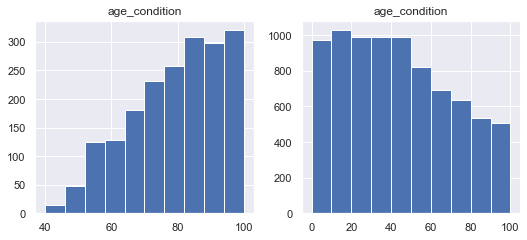

,cancer,no_cancer
mean,78.797488,43.081975
25%,69.000000,20.000000
50%,81.000000,40.000000
75%,90.000000,64.000000


In [2946]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

df1 = df_person_cancer
df2 = df_person_non_cancer

fig, axes = plt.subplots(1, 2)
df1.hist('age_condition', ax=axes[0])
df2.hist('age_condition', ax=axes[1])
plt.show()

# Ploting quantiles
data_vis_canc = df_person_cancer['age_condition'].describe()
data_vis_non_cancer = df_person_non_cancer['age_condition'].describe()
d = {'cancer': [data_vis_canc[1], data_vis_canc[4], data_vis_canc[5], data_vis_canc[6]], 
     'no_cancer': [data_vis_non_cancer[1], data_vis_non_cancer[4], data_vis_non_cancer[5], data_vis_non_cancer[6]]}
df_vis_patient = pd.DataFrame(d, index=['mean', '25%', '50%', '75%'])
display(df_vis_patient)

- The age distributions are very different between the cancer patients and the other patients. It means that if we want to compare these two populations we will need to filter 'df_non_cancer' to match the age of the cancer patients.

<a id="Cap4-2"></a>
# 4.2 Analysis of the cancer patients

Now that we have identified our population of interest and have eliminated the duplicates of patients, we can make use of descriptive statistics to know better the patients who suffer from lung cancer

In [2947]:
df_person_cancer.info()
nb_deaths = df_person_cancer[df_person_cancer['death_datetime'] != 0]['death_datetime'].count()
print(f'\nThe number of dead patients is {nb_deaths}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1911 entries, 13068 to 17259
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   visit_occurrence_id   1911 non-null   float64       
 1   visit_start_datetime  1911 non-null   datetime64[ns]
 2   unique_person_id      1911 non-null   float64       
 3   birth_datetime        1911 non-null   int64         
 4   death_datetime        1911 non-null   object        
 5   gender_source_value   1911 non-null   object        
 6   cdm_source            1911 non-null   object        
 7   diagnostic_date       1911 non-null   int64         
 8   person_id             1911 non-null   object        
 9   age_condition         1911 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 228.8+ KB

The number of dead patients is 1112


We have 1911 cancer patients in total and 58,18% have died during the study time.

-------
Analysing the sex distribution

male      976
female    935
Name: gender_source_value, dtype: int64


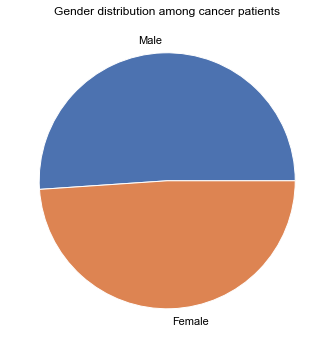

In [2948]:
data = df_person_cancer['gender_source_value'].value_counts()
print(data)
y = [data[0], data[1]]

fig, ax = plt.subplots(figsize=(8, 5), subplot_kw=dict(aspect="equal"))
mylabels = ["Male", "Female"]

plt.pie(y, labels = mylabels, textprops=dict(color="black"))
ax.set_title("Gender distribution among cancer patients")
ax.title.set_color('black')
plt.show() 


- We have a good balance (almost 50% to 50%) between male and female individuals, what might help the study to not be gender biased.

--------
Taking a closer look at the age of the studied population (when they were diagnosed with the condition)

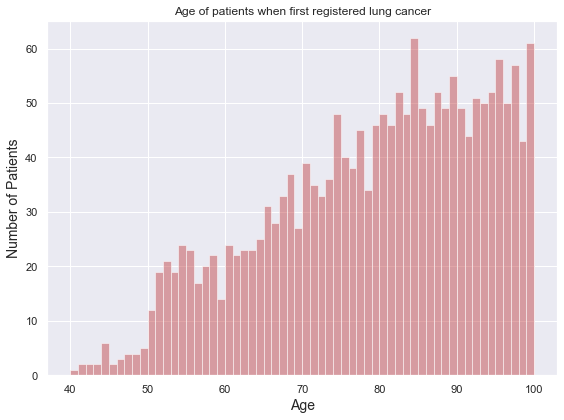

count    1911.000000
mean       78.797488
std        13.890308
min        40.000000
25%        69.000000
50%        81.000000
75%        90.000000
max       100.000000
Name: age_condition, dtype: float64

In [2949]:
data = df_person_cancer['age_condition']
plt.figure(figsize=(8,6))
plt.hist(data, bins=60, alpha=0.5, label=None, color='r')
plt.xlabel("Age", size=14)
plt.ylabel("Number of Patients", size=14)
plt.title("Age of patients when first registered lung cancer")
plt.show()
data.describe()

- We can observe by the descriptive statistic that age seems to be a very influent risk factor for lung cancer, as the mean age of the observed group is 78 year and 75% of the registered patients had more than 69 years of age.

Now, it is possible to investigate if age has a great contribution to the mortality of patients

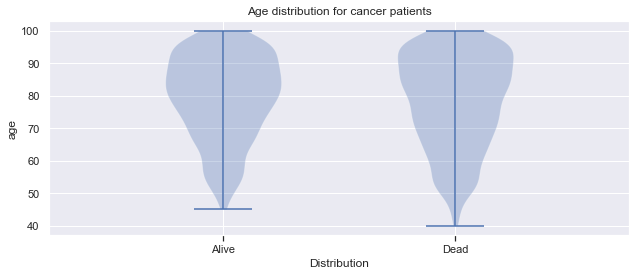

,alive,dead
mean,79.370463,78.385791
25%,71.000000,68.000000
50%,81.000000,81.000000
75%,90.000000,91.000000


In [2950]:
# Doing a violin plot of the two age distributions for dead and alive patients
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9, 4), sharey=True)
data = [df_person_cancer[df_person_cancer['death_datetime'] == 0]['age_condition'], 
        df_person_cancer[df_person_cancer['death_datetime'] != 0]['age_condition']]
ax1.set_title('Age distribution for cancer patients')
ax1.set_ylabel('age')
ax1.violinplot(data)
# Stylize
labels = ['Alive', 'Dead']
ax1.xaxis.set_tick_params(direction='out')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
ax1.set_xlim(0.25, len(labels) + 0.75)
ax1.set_xlabel('Distribution')
plt.show()
# Ploting the quantiles
data_vis_alive = df_person_cancer[df_person_cancer['death_datetime'] == 0]['age_condition'].describe()
data_vis_dead = df_person_cancer[df_person_cancer['death_datetime'] != 0]['age_condition'].describe()
d = {'alive': [data_vis_alive[1], data_vis_alive[4], data_vis_alive[5], data_vis_alive[6]], 
     'dead': [data_vis_dead[1], data_vis_dead[4], data_vis_dead[5], data_vis_dead[6]]}
df_vis_patient = pd.DataFrame(d, index=['mean', '25%', '50%', '75%'])
display(df_vis_patient)


- Surprisingly, it seems that age does not to play an important role in the mortality of the tumor, but just into the probability of develop cancer

We make a hypothesis test to check that

In [2951]:
from scipy.stats import ttest_ind, chi2_contingency
t_val = ttest_ind(data[1], data[0])[1]
print(f't value = {t_val} | Null hyphotesis not rejected')

t value = 0.1264129891604441 | Null hyphotesis not rejected


- We do not reject the null hypothesis, so we don't clearly have a distinction in mortality in function of age

<a id="Cap5"></a>
# 5. Checking for other conditions in patients with diagnosed lung cancer

First, we create a DataFrame that contains all the patients and their conditions

In [2952]:
def enhance_person(df_person, condition_list):
    '''This function creates a new row on df_person for each condition listed. It put as value a 0 if the patient
    doesn't present the condition and a 1 if the patient presents the condition
    '''
    df_person_cond = df_person.copy()
    for c in condition_list:
        df_person_cond[c] = 0
        list_ids = df_cond_fix.query(f"condition_source_value == '{c}'")['unique_person_id'].to_list()
        df_person_cond[c]  = df_person_cond.unique_person_id.apply(lambda id: True if id in list_ids else False)

    return df_person_cond


In [2953]:
all_codes = df_cond_fix.condition_source_value.unique()
df_person_cond = enhance_person(df_person_cancer, all_codes)
df_person_cond.head()

,visit_occurrence_id,visit_start_datetime,unique_person_id,birth_datetime,death_datetime,gender_source_value,cdm_source,diagnostic_date,person_id,age_condition,...,C343,C342,C34,C340,C341,E12,E11,I13,I12,B21
13068,87448186.0,2019-12-03,84419226.0,1941,2019-12-10 00:00:00,male,EHR 1,2019,84419226,78,...,True,False,False,False,False,False,False,False,True,False
13430,82712174.0,2019-12-04,80196328.0,1946,2019-12-05 00:00:00,male,EHR 1,2019,80196328,73,...,False,True,False,False,False,False,False,False,False,False
17964,80697997.0,2019-12-10,80469687.0,1924,0,male,EHR 1,2019,80469687,95,...,False,False,False,False,True,False,False,False,False,False
17963,87872165.0,2019-12-10,87447467.0,1924,0,male,EHR 1,2019,87447467,95,...,False,False,False,True,False,False,False,False,False,False
10896,85744009.0,2019-12-18,88490399.0,1957,2019-12-26 00:00:00,male,EHR 1,2019,88490399,62,...,True,False,False,False,False,False,False,False,False,False


-------
We can make a plot to see what are the most common conditions among the cancer patients

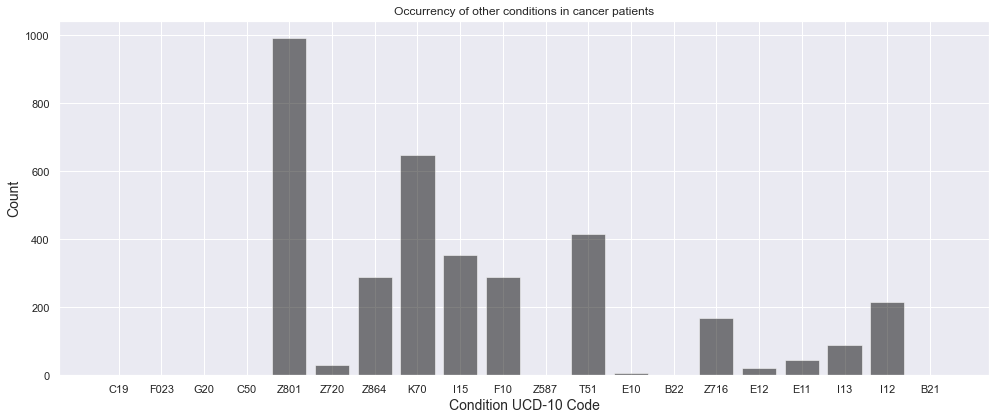

In [2954]:
list_df = list(df_person_cond)
# Summing each time a condition appears
x = [i for i in list_df[10:]]
for i in ['C343', 'C342', 'C341', 'C340', 'C34']:
    x.remove(i)
y = [df_person_cond[i].sum() for i in x]
# Ploting
data = df_person_cancer['age_condition']
plt.figure(figsize=(14,6))
plt.bar(x, y, alpha=0.5, label=None, color='black')
plt.xlabel("Condition UCD-10 Code", size=14)
plt.ylabel("Count", size=14)
plt.title("Occurrency of other conditions in cancer patients")
plt.show()

- We can notice that the condition that occurred the most is Z801, which is related to family antecedents of cancer.
- The alcool related conditions: K70, T51 and F10 are very expressive as well
- The appearing tobacco related conditions are: Z864, Z720 and Z716.
- Hypertension related conditions: I15 and I12
- Diabetes related conditions are: E10, E11 and E 12

These results are compatible with the studied bibliography, which brings these 5 factors as being significant risk factors for lung cancer. Despite that, the presented number of tobacco related conditions seems to be lower than expected, as medicine treats tobacco as a major risk factor to the development of lung cancer.

<a id="Cap5-1"></a>
# 5.1 - Relation with tobacco

In [2955]:
# Searching the number of patients which have a least one tobacco related condition
df_query = df_person_cond.query('(C343 == 1 or C342 == 1 or C341 == 1 or C340 == 1 or C34 == 1) and (Z720 == 1 or Z716 == 1 or Z587 == 1)')
nb_tabac = df_query['unique_person_id'].count()
print(f'We have a total of {nb_tabac} patients with lung cancer and at least another condition related to tobacco')

We have a total of 199 patients with lung cancer and at least another condition related to tobacco


- This number represents only 15,65% of the patients, result that is lower than expected due to the extensive literature that relates tobacco usage and lung cancer. This scenario might indicate that the number of occurrencies of conditions related to tobacco doesn't match the reality.

- To verify this hypothesis, it's possible to check the notes procuded by the doctors and available in df_notes and see if there are mentions to tobacco usage for patients that haven't been registered as poseding a tobacco related condition.

In [2956]:
import spacy
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from edsnlp import components
from edsnlp.processing.parallel import pipe as parallel_pipe
from spacy import displacy

In [2957]:
# We declare the terms related to cancer and tobacco
terms = dict(
    tabac=['tabac', 'fumeur', 'fumé','tabagisme', 'passif','drogue','fume','fumer','tabagique','consommation'],
    cancer=['cancer', 'poumon', 'tumeur','bronche'] 
)
nlp = spacy.blank("fr")
nlp.add_pipe("eds.sentences")
nlp.add_pipe("eds.normalizer")
nlp.add_pipe("eds.matcher", config=dict(terms=terms))
nlp.add_pipe("eds.negation")

In [2958]:
def pick_results(doc):
    """
    This function provides the entities that must be collected by the nlp process.
    """
    return [{
             'note_id':e.doc._.note_id,
             'visit_occurrence_id':e.doc._.visit_occurrence_id,
             'lexical_variant':e.text,
             'label':e.label_,
             'negation':e._.negation
             } 
             for e in doc.ents if doc.ents]

In [2959]:
df_nlp = parallel_pipe(
                df_note,
                nlp,
                context=['note_id', 'visit_occurrence_id'],
                progress_bar=False,
                n_jobs=1, 
                results_extractor = pick_results,
                )

In [2960]:
# We isolate the results with label 'tobacco' and that have no negation
df_nlp_tabac = df_nlp.query('label == "tabac" and negation == False')
notes_cancer = pd.merge(df_nlp_tabac, df_cond_fix, on='visit_occurrence_id', how='left')
notes_cancer_fix = pd.merge(notes_cancer, df_note, how='left', on='note_id')

In [2961]:
print("The F1 score for the nlp algorithm used is {}%".format(round(100*14/(14+(9/2)),2)))

The F1 score for the nlp algorithm used is 75.68%


This F1 score means that we, by applying the nlp conditions, are going to have the presence of false positives, that is people that don't actualy smoke being classed as smokers. Keeping that in mind, we cand add a tobacco condition to these patients when we make the statistical analysis.

<a id="Cap6"></a>
# 6. Comparing conditions and biological measures between cancer patients and the other patients

We are going to study if cancer patients present significant alterations on the values of:

- BMI: Body Mass index
- CRP: C-recreative protein - indicates a body inflammation when found in anormal quantities 
- UREA: An indicative for kidney function
- HB: Hemoglobin - a level decrease might indicate poor lung function

In [2962]:
def add_bio(df_person_cond, df_bio, list_bio):
    """This function add to df_person_cond the listed bio markes that are contained in df_bio"""
    df_person_cond_bio = df_person_cond.copy()
    for i in list_bio:
        df_bio_concept = df_bio.query(f'concept_source_value == "{i}"')
        df_person_cond_bio = pd.merge(df_person_cond_bio, df_bio_concept[['visit_occurrence_id','transformed_value']], how='left', on='visit_occurrence_id')
        df_person_cond_bio.rename(columns = {'transformed_value': i}, inplace = True)
    
    return df_person_cond_bio



- We can notice that the condition that occurred the most is Z801, which is related to family antecedents of cancer.
- The alcool related conditions: K70, T51 and F10 are very expressive as well
- The appearing tobacco related conditions are: Z864, Z720 and Z716.
- Hypertension related conditions: I15 and I12

These results are compatible with the studied bibliography, whom brings these 4 factors as being significant risk factors for lung cancer. Despite that, the presented number tobacco related conditions  seems to be lower than expecter, as medicine treats tobacco as one of the main risk factors related to the development of lung cancer.

In [2963]:
# Adding to df_person_all the important conditions and the bio markers
df_person_all_cond_bio = enhance_person(df_person_all, ['E10', 'E11', 'E12', 'I15', 'I12', 'K70', 'T51', 'F10', 'Z864', 'Z720', 'Z716', 'Z587', 'C343', 'C342', 'C341', 'C340', 'C34', 'Z716','Z720','Z587','Z801'])
df_person_all_cond_bio = add_bio(df_person_all_cond_bio, df_bio,['bmi', 'urea', 'hb', 'crp'])

In [2964]:
# Creating the rows 'dead', 'male' and 'cancer'. They have value 1 if the patient has that characteristic and 0 otherwise
df_person_all_cond_bio['dead'] = df_person_all_cond_bio.death_datetime.apply(lambda val: True if val == 0 else False)
df_person_all_cond_bio['male'] = df_person_all_cond_bio.gender_source_value.apply(lambda val: True if val == 'male' else False)
df_person_all_cond_bio['cancer'] = df_person_all_cond_bio.unique_person_id.apply(lambda val: True if val in df_person_cancer['unique_person_id'].tolist() else False )


In [2965]:
# Creating the boolean columns
# Alcohol
alcool_ids = df_person_all_cond_bio.query('K70 == True or T51 == True or F10 == True')['unique_person_id'].tolist()
df_person_all_cond_bio['alcool'] = df_person_all_cond_bio.unique_person_id.apply(lambda val: True if val in alcool_ids else False )
# tobacco
tobacco_ids = df_person_all_cond_bio.query('Z864 == True or Z720 == True or Z716 == True or Z587 == True')['unique_person_id'].tolist()
df_person_all_cond_bio['tobacco'] = df_person_all_cond_bio.unique_person_id.apply(lambda val: True if val in tobacco_ids else False )
# tobacco traité avec nlp
for i in ids_smoker:
    if i in tobacco_ids:
        pass
    else:
        tobacco_ids.append(i)
df_person_all_cond_bio['tobacco_nlp'] = df_person_all_cond_bio.unique_person_id.apply(lambda val: True if val in tobacco_ids else False )
# hypertension
hyp_ids = df_person_all_cond_bio.query('I15 == True or I12 == True')['unique_person_id'].tolist()
df_person_all_cond_bio['hypertension'] = df_person_all_cond_bio.unique_person_id.apply(lambda val: True if val in hyp_ids else False )
# diabetes
diab_ids = df_person_all_cond_bio.query('E10 == True or E11 == True or E12 == True')['unique_person_id'].tolist()
df_person_all_cond_bio['diabetes'] = df_person_all_cond_bio.unique_person_id.apply(lambda val: True if val in diab_ids else False )
# As genetics has only one cond
df_person_all_cond_bio.rename(columns = {'Z801':'genetics'}, inplace = True)

Regarding age, we create a new column called 'age', which indicates that a patient has more than 70 years of age.

In [2966]:
df_person_all_cond_bio['senior'] = df_person_all_cond_bio.age_condition.apply(lambda val: True if val >= 70 else False)

In [2967]:
# Dropping column we will no longer use
df_person_all_cond_bio = df_person_all_cond_bio.drop(columns=['gender_source_value', 'death_datetime', 'visit_occurrence_id', 'visit_start_datetime', 'birth_datetime', 'cdm_source', 'person_id'])
df_person_all_cond_bio = df_person_all_cond_bio.rename(columns=({"age_condition": "age"}))

df_person_all_cond_bio.head()

,unique_person_id,diagnostic_date,age,E10,E11,E12,I15,I12,K70,T51,...,crp,dead,male,cancer,alcool,tobacco,tobacco_nlp,hypertension,diabetes,senior
0,84419226.0,2019,78,False,False,False,False,True,False,True,...,4.54,False,True,True,True,False,False,True,False,True
1,80196328.0,2019,73,False,False,False,False,False,False,False,...,4.57,False,True,True,True,True,True,False,False,True
2,80469687.0,2019,95,False,False,False,False,False,False,True,...,4.66,True,True,True,True,False,False,False,False,True
3,87447467.0,2019,95,False,False,False,False,False,False,True,...,4.48,True,True,True,True,True,True,False,False,True
4,88490399.0,2019,62,False,False,False,False,False,False,False,...,4.84,False,True,True,False,False,True,False,False,False


We make a quick inspection on the biological values to detect anomalies

In [2968]:
display(df_person_all_cond_bio['urea'].describe())
display(df_person_all_cond_bio['hb'].describe())
display(df_person_all_cond_bio['crp'].describe())
display(df_person_all_cond_bio['bmi'].describe())

count    10072.000000
mean         2.216072
std          0.621636
min         -0.400000
25%          1.810000
50%          2.240000
75%          2.680000
max          3.830000
Name: urea, dtype: float64

count    10072.000000
mean        13.311823
std          1.641489
min          6.620000
25%         12.190000
50%         13.310000
75%         14.420000
max         20.200000
Name: hb, dtype: float64

count    10072.000000
mean         4.554364
std          0.321072
min          3.290000
25%          4.360000
50%          4.530000
75%          4.710000
max          6.620000
Name: crp, dtype: float64

count    10072.000000
mean        21.282531
std          3.250375
min          7.140000
25%         19.240000
50%         21.290000
75%         23.340000
max         33.250000
Name: bmi, dtype: float64

Everything seems to be coherent except for urea, which presents negative values and a very low 1st quantil. We perform then an adjustment on this column.

In [2969]:
df_person_all_cond_bio['urea'] = df_person_all_cond_bio.urea.apply(lambda val: 2.26 if val <= 1.81 else val)
df_person_all_cond_bio['urea'].describe()

count    10072.000000
mean         2.434046
std          0.373254
min          1.820000
25%          2.250000
50%          2.260000
75%          2.680000
max          3.830000
Name: urea, dtype: float64

--------
We can perform now hypothesis tests to know if the values from our dataset change from the cancer patients to the non cancer patients

In [2970]:
def prevalence(values):
    return values.sum()*100 / len(values)

In [2971]:
# Dictionary with all the columns that are going to be studied
agg_dict = {
    "unique_person_id": ["count"],
    "senior": [prevalence],
    "male": [prevalence],
    "dead" : [prevalence],
    "genetics" : [prevalence],
    "alcool": [prevalence],
    "hypertension": [prevalence],
    "tobacco": [prevalence],
    "tobacco_nlp": [prevalence],
    "diabetes": [prevalence],
    "bmi" : [np.mean, np.std],
    "crp": [np.mean, np.std],
    "hb": [np.mean, np.std],
    "urea": [np.mean, np.std],
}

We filter the population to only have patients with more than 20 years of age due to the biological parameters, that might present too different value ranges between teenagers, children and adults.

In [2972]:
data = df_person_all_cond_bio.copy()
data = data[data['age'] >= 20]

In [2973]:
data_summary = round(data.groupby("cancer").agg(agg_dict).T,2)
data_summary

,cancer,False,True
unique_person_id,count,6161.00,1911.00
senior,prevalence,27.20,74.10
male,prevalence,49.94,51.07
dead,prevalence,99.38,41.81
genetics,prevalence,5.49,51.96
alcool,prevalence,60.75,70.85
hypertension,prevalence,6.49,29.83
tobacco,prevalence,10.10,25.54
tobacco_nlp,prevalence,33.99,49.76
diabetes,prevalence,2.35,3.87


In [2974]:
data_alive = data.query("cancer==False")
data_dead = data.query("cancer==True")
numerical = ["age", "bmi", "crp", "hb", "urea"]
test_categorical = ["male", "dead", "alcool", "hypertension", 'tobacco', 'tobacco_nlp', 'diabetes', 'genetics']
# Building the data summary
for feat, sub_value in data_summary.index:
    if sub_value == 'std':
        continue
    if feat in numerical:
        data_summary.loc[(feat,sub_value),"t-test"] = round(ttest_ind(data_alive[feat], data_dead[feat])[1],4)

    if feat in test_categorical:
        data_summary.loc[(feat,sub_value),"chi-sq"] = round(chi2_contingency(pd.crosstab(data["cancer"], data[feat]))[1],4)

data_summary


,cancer,False,True,chi-sq,t-test
unique_person_id,count,6161.00,1911.00,NaN,NaN
senior,prevalence,27.20,74.10,NaN,NaN
male,prevalence,49.94,51.07,0.4028,NaN
dead,prevalence,99.38,41.81,0.0000,NaN
genetics,prevalence,5.49,51.96,0.0000,NaN
alcool,prevalence,60.75,70.85,0.0000,NaN
hypertension,prevalence,6.49,29.83,0.0000,NaN
tobacco,prevalence,10.10,25.54,0.0000,NaN
tobacco_nlp,prevalence,33.99,49.76,0.0000,NaN
diabetes,prevalence,2.35,3.87,0.0005,NaN


Regarding the biological measures:
     
- It seems that patients with cancer don't present significant differences from the rest of the population regarding body max index, crp and hemoglobine. This observation is not in accord with bibliography, which states that decreased hemoglobin levels are significantly associated a high mortality tax among lung cancer patients. As 58% of the cancer patients died during the study observation time, we could expect hb to be lower on cancer patients than in the rest of the population. It might indicate that the data concerning this measure is not very exact or have been compromised.
     
- We can also observe that urea is, as show by the ttest, higher in cancer patients than in the rest of the population. We are going to further investigate this result in the statistical analysis section.

Regarding prevalence:

- We have a huge part of the population, with and without cancer, that has been diagnosed with alcohol related conditions. It might be a bias of the population we are studying and could compromise the understanding of the influence of the alcohol as risk factor for lung cancer.
- In all the conditions we have chi-sq test confirming a significant change on the mean between cancer and non cancer patients. This result might be biased due to the size o the population.

<a id="Cap6-1"></a>
# 6.1 - Statistical Analysis

Finally, we are going to inspect which factor are more os less influent on lung cancer trough linera regressions

<a id="Cap6-1-1"></a>
# 6.1.1 - Logistic Regression

In [2975]:
from statsmodels.formula.api import logit, glm

In [2976]:
categorical = ["senior", "male", "cancer", "genetics", "alcool", "tobacco", "tobacco_nlp", "hypertension", "diabetes"]
data[categorical] = data[categorical].astype(int)

In [2977]:
# Ploting the values obtained by logistic regression
dic_regr = {}
for feat in ["senior", "male", "genetics", "alcool", "tobacco", "tobacco_nlp", "hypertension", "diabetes", "urea", "crp", "bmi", "hb"]:
    model = logit(f"cancer ~  {feat}", data).fit(disp=False)
    dic_regr[feat] = [(round(np.exp(model.params[feat]),2))]

display(pd.DataFrame(dic_regr, index=['Logistic Regression']))

,senior,male,genetics,alcool,tobacco,tobacco_nlp,hypertension,diabetes,urea,crp,bmi,hb
Logistic Regression,7.66,1.05,18.64,1.57,3.05,1.92,6.12,1.67,8.53,0.94,1.01,1.0


We observe that:
 - Genetics seems to be the most influent risk factor
 - Urea, age, hypertension and tobacco are the other risk factor that seem to influence lung cancer

As we have several parameters, we need to make a regression taking into account their combined action. Thus, we perform a GLM.

<a id="Cap6-1-2"></a>
# 6.1.2 GLM

In [2978]:
model = glm("cancer ~ senior + male + genetics + hypertension + alcool + tobacco + tobacco_nlp + diabetes + bmi + crp + hb + urea", data).fit()

In [2979]:
# Ploting values obtained by GLM
dic_glm = {}
for feat, param in model.params.to_dict().items():
    dic_glm[feat] = [(round(np.exp(model.params[feat]),2))]
display(pd.DataFrame(dic_glm, index=['GLM']))

,Intercept,senior,male,genetics,hypertension,alcool,tobacco,tobacco_nlp,diabetes,bmi,crp,hb,urea
GLM,0.81,1.2,0.99,1.66,1.13,1.02,1.13,1.03,0.98,1.0,1.0,1.0,1.1


- We observe that genetics is still the most influent risk factor.
- Urea, age, hypertension and tobacco are still influent as well, but now urea is the least influent among them. This might happen due to possible correlations between urea and other parameters

We can plot a heatmap to analise these correlations:

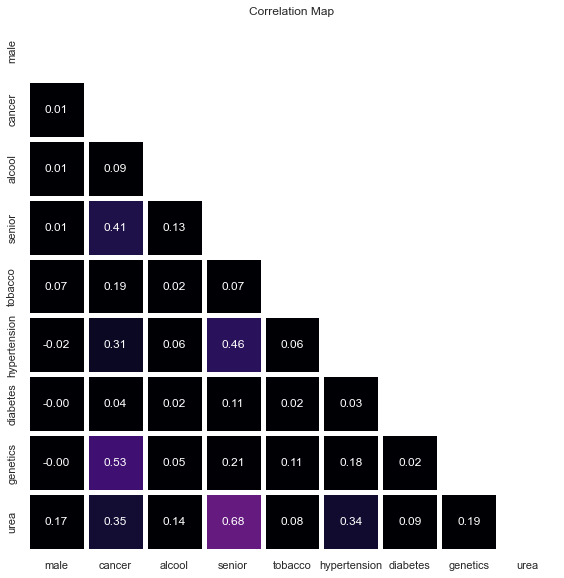

In [2980]:
import seaborn as sns

df_corr = data[['male', 'cancer', 'alcool', 'senior', 'tobacco', 'hypertension', 'diabetes', 'genetics', 'urea']].corr()
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 10))
    ax = sns.heatmap(df_corr, mask=mask,  square=True, linewidth=3.1, cmap='magma', annot=True, center=1, fmt=".2f", cbar=False, vmin=0.2)
plt.title('Correlation Map')
plt.show()

- We observe that, indeed, urea is correlated to age, hypertention and cancer, the strongest correlation being with age. 
- We also observe a correlation between hypertension and age.
- Therefore, one hypothesis we can formulate is that cancer is more likely to happen in older people. As age is correlated with hypertension and higher levels of urea, we have the correlation between cancer and hypertension as well as between cancer an urea.
- As age is not correlated to tobacco and alcool, we can consider these two as important risk factors to lung cancer.

<a id="Conc"></a>
# 7. Conclusion

- The genectic factor seems to be the most relevant risk factor for lung cancer.
- There is also a significant influence of age, tobacco conditions and hypertension on lung cancer.
- Haven't been observer a clear influence of alcohol, despite bibliography, what might be caused by a population bias.
- Concerning the biology measures: 
    - An influence of the urea level in the blood was observed, which only confirms that patients with cancer are older than the general population of patients, as urea is correlated with age.
    - No significant influences of body mass index and crp on lung cancer have been observed.
    - Despite bibliography, no significant influence of hemoglobine count on lung cancer have ben observed, which might be caused by imprecision on the measures of theses values.